# Image recognition with Python, Tensorflow and Keras
### *A ridiculously inadequate introduction*

The packages might seem over-the-top in the sense that it's a lot but because I like to implement a lot of different solutions and run-time can vary ***A LOT*** between packages, I like to borrow stuff from different packages.

... and by "a lot" I mean the difference can be between a few hours to weeks

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.constraints import maxnorm
from keras.utils import np_utils
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import keras.applications as models
from keras.applications.vgg16 import preprocess_input
import urllib.request
import pandas as pd
import lodgepole.image_tools as lit
from keras.datasets import cifar10

2022-03-22 18:13:24.348569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 18:13:24.348606: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Setting a seed so we can reproduce

In [2]:
seed = 420

Importing the dataset - we will use the cifar10-dataset that consists of images of 10 classes:

* Birds
* Dogs
* Arplanes
* Atomobile
* Deer
* Frog
* Horse
* Ship
* Truck

We also split them into four different sets - training data that consists of 50.000 images and labels and test data that consists of 10.000 images and labels. This is considered a small dataset.

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 7s 0us/step


First we just have a loot at the data:

In [5]:
len(X_train)

50000

In [6]:
len(X_test)

10000

In [7]:
X_train.shape

(50000, 32, 32, 3)

In [8]:
X_train[0].shape

(32, 32, 3)

In [9]:
print(y_train[0])

[6]


In [10]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


Let's have a look at some of the images:

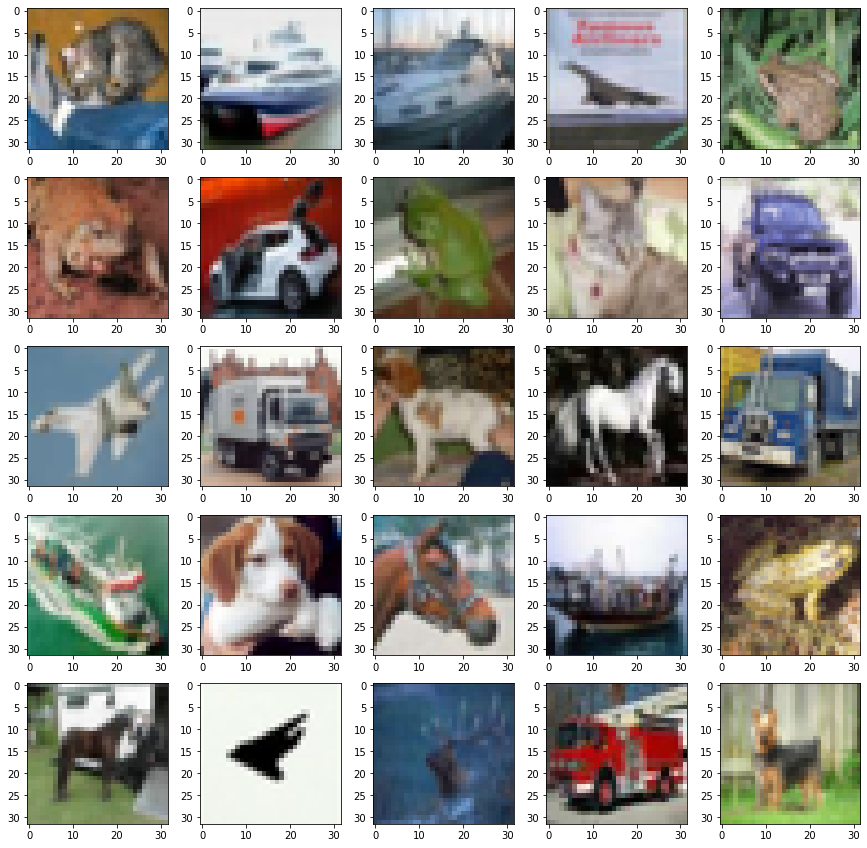

In [11]:
plt.figure(figsize=(15,15))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])

plt.show()

Let's store a single element (picture) from the array (element 0) - it's a picture of a dog. This is how python sees the image:

In [12]:
img=X_test[0]
print(img)
img.shape

[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 148]
  [ 31  88 137]
  ...
  [ 38  97 146]
  [ 13  64 108]
  [ 40  85 127]]

 [[ 61 116 168]
  [ 49 102 148]
  [ 35  85 132]
  ...
  [ 26  82 130]
  [ 29  82 126]
  [ 20  64 107]]

 [[ 54 107 160]
  [ 56 105 149]
  [ 45  89 132]
  ...
  [ 24  77 124]
  [ 34  84 129]
  [ 21  67 110]]]


(32, 32, 3)

And how Python shows it using ``imshow``

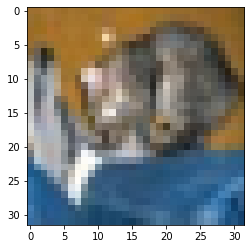

In [13]:
plt.imshow(img)

This is a way to turn the image into a true grayscale - going from 3D to 2D array:

In [14]:
gray_img = lit.rgb2gray(img)

And this is what it looks like:

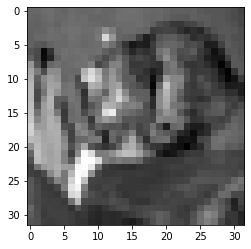

In [15]:
plt.imshow(gray_img, cmap='gray')

And this is how Python stores the information as a 2D array:

In [16]:
img = np.array(gray_img)
print(img)

[[121.28419737 120.91733281 126.04011386 ... 103.69969928  97.74459076
   90.77853484]
 [119.50979572 117.69841422 122.7990149  ... 103.3120102   97.37603361
   93.65313968]
 [117.82397766 116.95026762 120.42723008 ... 106.20015341 101.51667789
   94.58919371]
 ...
 [120.57856039  96.87501341  85.81215001 ...  94.11852317  63.27711888
   82.80763853]
 [112.85896929  98.87964734  83.13049039 ...  80.15257281  79.73804205
   63.35390899]
 [104.55177585 101.84598422  86.82900511 ...  75.52301127  81.91713126
   66.02639815]]


And the shape:

In [17]:
img.shape

(32, 32)

How to go from 2D to 1D array:

In [18]:
img = img.flatten()

In [19]:
img.shape

(1024,)

In [20]:
print(img)

[121.28419737 120.91733281 126.04011386 ...  75.52301127  81.91713126
  66.02639815]


Aaaaaand now we're bored with that image... GTFO:

In [21]:
del img

In general, NN's enjoy data that can be stored as ranges between 0 and 1. This makes sure that values that are high stay high relative to other values. Since RGB has values between 0 and 255, we can store them as floats (with a lot of decimals) and then divide them by max value:

In [22]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [23]:
print(X_train[0])

[[[0.23137255 0.24313726 0.24705882]
  [0.16862746 0.18039216 0.1764706 ]
  [0.19607843 0.1882353  0.16862746]
  ...
  [0.61960787 0.5176471  0.42352942]
  [0.59607846 0.49019608 0.4       ]
  [0.5803922  0.4862745  0.40392157]]

 [[0.0627451  0.07843138 0.07843138]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509805 0.21568628]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117648 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215687 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941177 0.19607843]
  [0.47058824 0.32941177 0.19607843]
  [0.42745098 0.28627452 0.16470589]]

 ...

 [[0.8156863  0.6666667  0.3764706 ]
  [0.7882353  0.6        0.13333334]
  [0.7764706  0.6313726  0.10196079]
  ...
  [0.627451   0.52156866 0.27450982]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333334 0.07843138]]

 [[0.7058824  0.54509807 0.3764706 ]
  [0.6784314  0.48235294 0.16470589]


For now, element 0 of the array (the one that points to the picture of the dog) is giving us the value 6. This is fine except that it isn't - we need 10 classes and we need the information about the classes that the picture isn't stored there as well

In [24]:
print(y_train[0])

[6]


A nifty way of storing all that information is a version of "one-hot encoding" that allows for an array to be transformed from a sinle value to a list of all the potential values as 0/1 statements. Since this image is 6, the sixth value is 1 while the others are set to 0.

In [25]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

In [26]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


We need to be able to refer to the number of classes at some point, so we might as well store that here.

In [27]:
print(class_num)

10


Now the fun begins. We build the model. Keras has this nifty trick where we can call the ``Sequential``-method, where we call the method and then add on to the model sequentially (hence the name). First we name the model... I am not very good at naming it and my intuition told me that the name should be either "cat" or "hat" but since that is often confusing, I went with a more mundane choice of calling my model "model"

In [28]:
model = keras.Sequential()

2022-03-22 18:14:39.599850: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-22 18:14:39.599903: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (j-60823-job-0): /proc/driver/nvidia/version does not exist
2022-03-22 18:14:39.600917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


No way I'm describing what the hell is going on here so instead I am going to talk about it for quite some time

In [29]:
model.add(keras.layers.Conv2D(32, 3, input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
    
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(class_num, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

Now... don't run this next cell untill I tell you to. It is slow and boring. This is where we train the model.

In [30]:
np.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=28)

Epoch 1/2
1786/1786 [==============================] - 75s 41ms/step - loss: 1.5451 - accuracy: 0.4490 - val_loss: 1.1557 - val_accuracy: 0.5871
Epoch 2/2
1786/1786 [==============================] - 73s 41ms/step - loss: 1.1322 - accuracy: 0.6019 - val_loss: 0.9103 - val_accuracy: 0.6803


And this is where we evaluate our model. An accuracy of around 68% is quite poor but we also didn't give it very many chances.

In [31]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.9103 - accuracy: 0.6803


[0.9102960228919983, 0.6802999973297119]

In our evaluation, we are looking for the place where accuracy is maximized and loss is minimized. Often times, they flatten out at some point and in some cases, we see the loss increasing at the end - this means we are over-fitting our model.

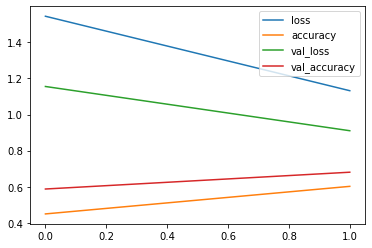

In [32]:
pd.DataFrame(history.history).plot()
plt.show()

# Round 2: Transfer learning
### *Aka: Let's steal some shit*

Keras has inbuilt all the fancy models and the EfficientNetB0 is one of the "smaller" NN's out there. Loading the model is actually pretty easy:

In [33]:
effnet = keras.applications.EfficientNetB0(weights='imagenet', include_top=True)
effnet.summary()

21848064/21834768 [==============================] - 1s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

Now, before we retrain our model, let's see what it can do. See if you can find a picture on the internet. Use google and search for images of whatever... it would be fun if you found something weird but it might not recognize it. Give it a shot. Right click on the image and click on "Open image in new window" and cooy/paste the url to the code below. If you did that and run the code, you should see the picture printed below. If you picked an image that wans't square, it might look squeezed - that's because effnet needs images that are 224 by 224 pixels and the code below rescales the image to those parameters. It's fine.

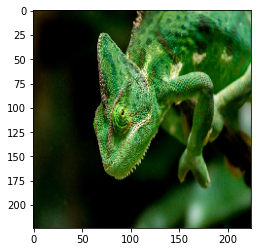

In [53]:
url = 'https://i1.wp.com/thespoon.tech/wp-content/uploads/2021/10/chameleon-g8bb4fe558_1920.jpg?fit=1200,800&ssl=1'
urllib.request.urlretrieve(url, 'stuff.jpg')

file = image.load_img('stuff.jpg', target_size=(224, 224))
plt.imshow(file)

Now let's ready the image to the prediction. We need to change it to an array and since effnet needs input in the shape of (0,224,224,3) we need to expand the dimensions to inlcude the 1 at the beginning. This is done by ``img = np.expand_dims(img, 0)`` which I will agree is a little weird... but that's how it's done.

We might also consider running a preproccessor on the images (part of Tensorflow) that expands on the features that seems most important by boosting colors (adding more values to things so green becomes ***GREEN*** and black becomes ***BLACK***

In [35]:
img = image.img_to_array(file)
img = np.expand_dims(img, 0)
img_preprocessed = preprocess_input(img)
img.shape

(1, 224, 224, 3)

Let's predict our image - did it get it right?

In [36]:
pred = effnet.predict(img)

In [37]:
print(keras.applications.imagenet_utils.decode_predictions(pred))

49152/35363 [=========================================] - 0s 0us/step
[[('n01694178', 'African_chameleon', 0.96988714), ('n01693334', 'green_lizard', 0.013922761), ('n01682714', 'American_chameleon', 0.004277121), ('n01687978', 'agama', 0.0029406175), ('n01677366', 'common_iguana', 0.0014232758)]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


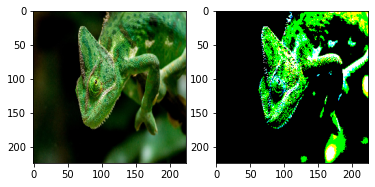

In [38]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(file))
ax[1].imshow(np.squeeze(img_preprocessed))

Maybe the preprocessed image is better?

In [39]:
pred = effnet.predict(img_preprocessed)
print(keras.applications.imagenet_utils.decode_predictions(pred))

[[('n01694178', 'African_chameleon', 0.93312615), ('n01693334', 'green_lizard', 0.035087317), ('n01682714', 'American_chameleon', 0.013959685), ('n01687978', 'agama', 0.0041268626), ('n01677366', 'common_iguana', 0.0025747488)]]


Now we might want to see what the different types of outputs of random things in the network actually produces. This can be done by:

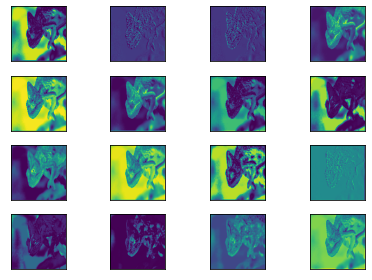

In [40]:
model = keras.Model(inputs=effnet.inputs, outputs=effnet.layers[6].output)
feature_maps = model.predict(img_preprocessed)

ix = 1
for _ in range(4):
    for _ in range(4):
        ax = plt.subplot(4, 4, ix)
        ax.imshow(feature_maps[0, :, :, ix-1])
        ax.set_xticks([])
        ax.set_yticks([])
        ix += 1
        
plt.tight_layout()
plt.show()

#### ***You wouldn't steal a car; You wouldn't steal a handbag; You wouldn't steal a television; You wouldn't steal a movie; Downloading pirated neural nets***........ luckily, isn't a crime so just download some shit and have fun with it

Let's download effnet again but set the "top" as false. This means that the input needs to be the same but that we are able to change what it predicts and other smaller/larger things in the end of the pipeline. We set a very important parameter ``effnet_base.trainable = False`` so that when we train our new model, we don't retrain the entire network. Without GPU-support, this would take years (and this is not an overstatement, it will actually take years)

In [41]:
effnet_base = keras.applications.EfficientNetB0(weights='imagenet', 
                                          include_top=False, 
                                          input_shape=((224, 224, 3)))

effnet_base.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


Now, let's have a look at effnet:

In [42]:
effnet_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

Because Keras is sequential, we can add our own stuff to that sequence - this is important but also very confusing so I will tell you about it

In [43]:
new_model = keras.Sequential()
new_model.add(effnet_base)
new_model.add(keras.layers.Conv2D(7,7))
new_model.add(keras.layers.BatchNormalization())
new_model.add(keras.layers.GlobalAveragePooling2D())
new_model.add(keras.layers.Dropout(0.2))
new_model.add(keras.layers.Flatten())
new_model.add(keras.layers.Dense(512, activation='relu'))
new_model.add(keras.layers.Dense(10, activation='softmax'))

What is trainable?

In [44]:
for index, layer in enumerate(new_model.layers):
    print("Layer: {}, Trainable: {}".format(index, layer.trainable))

Layer: 0, Trainable: False
Layer: 1, Trainable: True
Layer: 2, Trainable: True
Layer: 3, Trainable: True
Layer: 4, Trainable: True
Layer: 5, Trainable: True
Layer: 6, Trainable: True
Layer: 7, Trainable: True


Now we load cifar10 again but in a different way from a different souce - this allows us to add string labels and other cool stuff:

In [45]:
dataset, info = tfds.load("cifar10", as_supervised=True, with_info=True)

class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

print(class_names)

2022-03-22 18:17:40.904404: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /home/ucloud/tensorflow_datasets/cifar10/3.0.2.incompleteSL6PTV/cifar10-train.tfrecord*...:   0%|   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /home/ucloud/tensorflow_datasets/cifar10/3.0.2.incompleteSL6PTV/cifar10-test.tfrecord*...:   0%|    …

Dataset cifar10 downloaded and prepared to /home/ucloud/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Still 10 classes:

In [46]:
print(n_classes)

10


Here we do our split but now we have a third group; validation. This means we have train/test as before but we save something that is used instead of the test-set - the validation set. This means that 0% of the test-set is used as validation instead of random things from there that might "bleed" into the final score.

In [47]:
test_set, valid_set, train_set = tfds.load("cifar10", split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

print("Train set size: ", len(train_set))
print("Test set size: ", len(test_set))
print("Valid set size: ", len(valid_set))

Train set size:  37500
Test set size:  5000
Valid set size:  7500


This is me showing you how to apply different small changes to images so that we either boost sample size or force more learning:

In [48]:
def preprocess_image(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    img = tf.image.random_flip_left_right(resized_image)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.rot90(img)
    return img, label

Since all of this is arrays and effnet expects us to tell it the size of the batches we feed it, we add batch size to all our data. This moves arrays from:

224,224,3 to 64,224,224,3

It's just how this type of transfer learning call works - better to add batch size in the input and not specify it because the model easily gets confused:

In [49]:
train_set = train_set.map(preprocess_image).batch(64).prefetch(1)
test_set = test_set.map(preprocess_image).batch(64).prefetch(1)
valid_set = valid_set.map(preprocess_image).batch(64).prefetch(1)

***DO NOT RUN THIS BEFORE I SAY "GO"***

We can specify specific parameters for basically anything in our model. Here I change the learning rate of the model by telling the optimizer what to do and then I fit the model.

In [50]:
optimizer = keras.optimizers.Adam(learning_rate=2e-5)

new_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = new_model.fit(train_set, epochs=2, validation_data=valid_set)

Epoch 1/2
586/586 [==============================] - 268s 450ms/step - loss: 2.0247 - accuracy: 0.3862 - val_loss: 1.7503 - val_accuracy: 0.5285
Epoch 2/2
586/586 [==============================] - 265s 452ms/step - loss: 1.6377 - accuracy: 0.5425 - val_loss: 1.4038 - val_accuracy: 0.6696


In [51]:
new_model.evaluate(test_set)

79/79 [==============================] - 29s 358ms/step - loss: 1.3885 - accuracy: 0.6832


[1.3884949684143066, 0.6832000017166138]

Let's visualize what our model actually did with stuff:

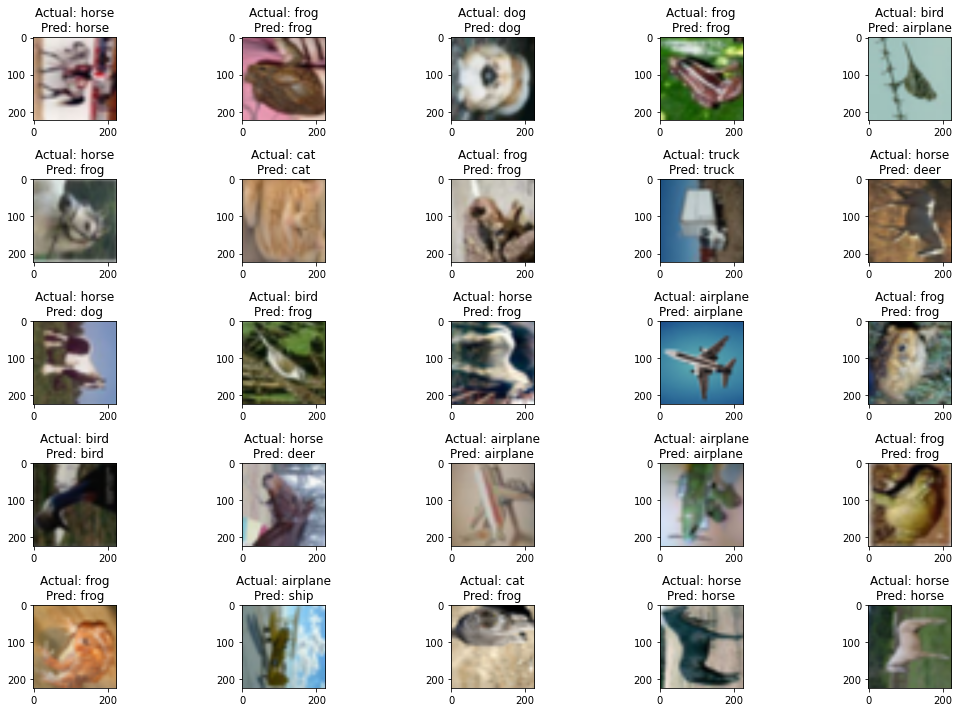

In [52]:
fig = plt.figure(figsize=(15, 10))

i = 1
for entry in test_set.take(25):
    pred = np.argmax(new_model.predict(entry[0].numpy()[0].reshape(1, 224, 224, 3)))
    sample_image = entry[0].numpy()[0]
    sample_label = class_names[entry[1].numpy()[0]]
    prediction_label = class_names[pred]
    ax = fig.add_subplot(5, 5, i)
    ax.imshow(np.array(sample_image, np.int32))
    ax.set_title("Actual: %s\nPred: %s" % (sample_label, prediction_label))
    i = i+1

plt.tight_layout()
plt.show()